## **BSCS16063 Assignment5**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd drive/My Drive/deep_assignments/Assignment5/data/Assignment 5 Dataset/

/content/drive/My Drive/deep_assignments/Assignment5/data/Assignment 5 Dataset


In [4]:
ls

desktop.ini                test/                   vgg16_FC_Last6Conv.pth
‘res18_entire.pth          train/                  vgg16_FC_Only_1000.pth
res18_FC_LastLayer4.pth    validation/             vgg16_FC_Only.pth
res18_FC_Only_LR_0001.pth  vgg16_entire.pth
res18_FC_Only.pth          vgg16_FC_Last3Conv.pth


Import Libraries


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import matplotlib.image as mpimg 
import glob
from PIL import Image
from sklearn.metrics import f1_score

# Load Dataset

In [0]:
data_dir = 'drive/My Drive/deep_assignments/Assignment5/data/Assignment 5 Dataset'

In [7]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize(256),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(root='train', transform=train_transforms)
test_data = datasets.ImageFolder(root= 'test', transform=test_transforms)
valid_data = datasets.ImageFolder(root= 'validation', transform=test_transforms)

print(len(valid_data))
print(len(train_data))
print(len(test_data))

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True,num_workers=4)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True,num_workers=4)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True,num_workers=4)

print(len(trainloader))

print("Classes: ")
class_names = train_data.classes
print(class_names)

1500
12000
1500
188
Classes: 
['infected', 'normal']


# Show Sample Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


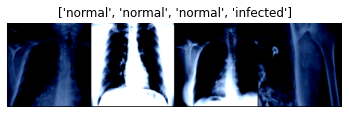

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

# Load Pretrained VGG16

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Fine Tune VGG16

In [0]:
features = list(vgg16.classifier.children())[:-7] # Remove last FC layers
features

[]

In [0]:
for para in vgg16.features.parameters():
  para.require_grad=False
  print(para.require_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [0]:
for k in vgg16.features.parameters():
  k.requires_grad=False

  print(k.requires_grad)
  

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [0]:
features.extend([nn.Linear(in_features=25088,out_features=630+1000,bias=True)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5,inplace=False)])
features.extend([nn.Linear(in_features=630+1000,out_features=2,bias=False)])
features

[Linear(in_features=25088, out_features=1630, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=1630, out_features=2, bias=False)]

In [0]:
vgg16.classifier=nn.Sequential(*features)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Train VGG16 with LR=0.001 and FC= (63*10)+1000


In [0]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
# vg.train(mode=True)

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)


Train: epoch:  0 total_correct:  9699.0 total_loss:  79.14438435435295
Valid: epoch:  0 total_correct:  1305 total_loss:  8.059097170829773
 
Train: epoch:  1 total_correct:  10246.0 total_loss:  66.27044239640236
Valid: epoch:  1 total_correct:  1315 total_loss:  6.938059613108635
 
Train: epoch:  2 total_correct:  10344.0 total_loss:  62.32302510738373
Valid: epoch:  2 total_correct:  1304 total_loss:  7.616011947393417
 
Train: epoch:  3 total_correct:  10400.0 total_loss:  61.205206885933876
Valid: epoch:  3 total_correct:  1314 total_loss:  7.275515124201775
 
Train: epoch:  4 total_correct:  10439.0 total_loss:  59.12105476856232
Valid: epoch:  4 total_correct:  1316 total_loss:  6.829804882407188
 
Train: epoch:  5 total_correct:  10474.0 total_loss:  59.614835783839226
Valid: epoch:  5 total_correct:  1322 total_loss:  6.761275380849838
 
Train: epoch:  6 total_correct:  10550.0 total_loss:  56.391961216926575
Valid: epoch:  6 total_correct:  1331 total_loss:  6.714375704526901

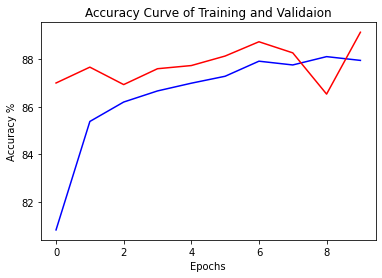

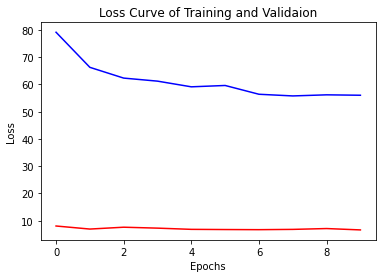

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


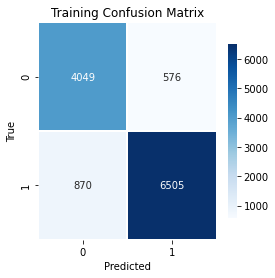

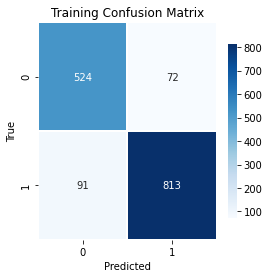

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

  vgg16.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # pbar = tqdm(enumerate(trainloader))
  train_p=[]
  train_l=[]

  for i, data in enumerate(trainloader, 0):

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = vgg16(inputs)               #----> forward pass
    _, predicted = torch.max(outputs.data, 1)

    loss = criterion(outputs, labels)   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    total_correct += get_num_correct(outputs, labels)
    

    train_p.extend(predicted.cpu().numpy())
    train_l.extend(labels.cpu().numpy())
    
  

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss)
  torch.save(vgg16,"vgg16_FC_Only_1000.pth")

  vgg16.eval()
  from sklearn.metrics import confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = vgg16(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          loss = criterion(outputs, labels)
          running_loss += loss.item()

          valid_p.extend(predicted.cpu().numpy())
          valid_l.extend(labels.cpu().numpy())

  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss)
  print(" ")

print("Training Accuracy",a,"%")

print("Validation Accuracy",((100 * correct) / total),"%")

print('Finished Training')



plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)

import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()


# Testing VGG16


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


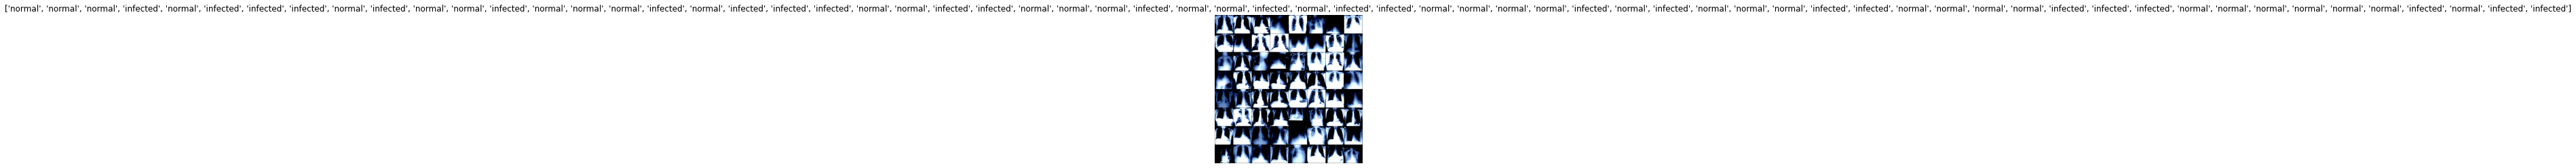

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal normal infected normal infected infected infected normal infected normal normal infected normal normal normal infected normal infected infected infected normal normal infected infected normal normal normal infected normal infected infected normal normal infected normal normal normal normal infected normal normal normal normal normal infected normal normal normal normal normal infected infected infected normal normal normal normal normal normal infected normal infected infected
Ground Truth:  normal normal normal infected normal infected infected infected normal infected normal normal infected normal normal normal infected normal infected infected infected normal normal infected infected normal normal normal infected normal normal infected normal infected infected normal normal normal normal infected normal infected normal normal normal infected infected normal normal normal normal infected infected infected normal normal normal normal normal normal infected no

In [0]:
vgg16=torch.load("vgg16_FC_Only_1000.pth")
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Accuracy of the network on the test images: 95 %
F1 Score : 0.959251101321586


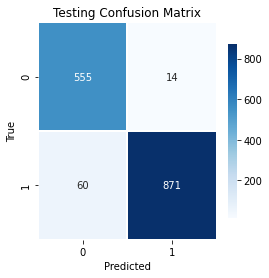

In [0]:
from sklearn.metrics import confusion_matrix
correct = 0
total = 0
p=[]
l=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        p.extend(predicted.cpu().numpy())
        l.extend(labels.cpu().numpy())

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))


# p=np.array(p)
# l=np.array(l)
input=confusion_matrix(p,l)
# print 'Confusion Matrix :'
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(input,cmap="Blues", annot=True,fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix")
# ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=22)
# ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=22)

from sklearn.metrics import f1_score
print("F1 Score :",f1_score(l, p)) # p are predicted labels and l are true labels


# Train **VGG16** with different Learning rate 0.0001 FC= (63*10)+1000



In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
features = list(vgg16.classifier.children())[:-7] # Remove last FC layers
features

[]

In [0]:
for para in vgg16.features.parameters():
  para.require_grad=False
  print(para.require_grad)

In [0]:
for k in vgg16.features.parameters():
  k.requires_grad=False

  print(k.requires_grad)
  

In [0]:
features.extend([nn.Linear(in_features=25088,out_features=630+1000,bias=True)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5,inplace=False)])
features.extend([nn.Linear(in_features=630+1000,out_features=2,bias=False)])
features

[Linear(in_features=25088, out_features=1630, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=1630, out_features=2, bias=False)]

In [0]:

vgg16.classifier=nn.Sequential(*features)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
# vg.train(mode=True)

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.9)


Train: epoch:  0 total_correct:  8777.0 total_loss:  103.54833716154099
Valid: epoch:  0 total_correct:  1242 total_loss:  9.79339611530304
 
Train: epoch:  1 total_correct:  9797.0 total_loss:  82.40822622179985
Valid: epoch:  1 total_correct:  1257 total_loss:  8.809514433145523
 
Train: epoch:  2 total_correct:  9989.0 total_loss:  75.83787813782692
Valid: epoch:  2 total_correct:  1284 total_loss:  8.293874278664589
 
Train: epoch:  3 total_correct:  10103.0 total_loss:  71.9580579996109
Valid: epoch:  3 total_correct:  1294 total_loss:  8.096604809165001
 
Train: epoch:  4 total_correct:  10156.0 total_loss:  69.85756056010723
Valid: epoch:  4 total_correct:  1300 total_loss:  7.754506677389145
 
Train: epoch:  5 total_correct:  10257.0 total_loss:  67.43354958295822
Valid: epoch:  5 total_correct:  1310 total_loss:  7.469965368509293
 
Train: epoch:  6 total_correct:  10253.0 total_loss:  65.99171900749207
Valid: epoch:  6 total_correct:  1312 total_loss:  7.316668897867203
 
Tra

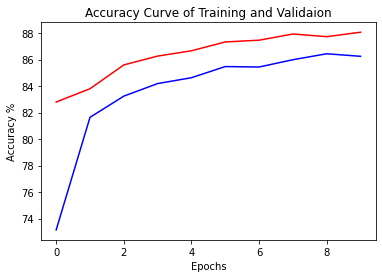

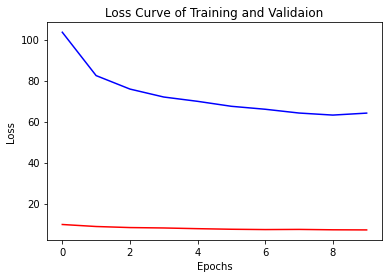

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


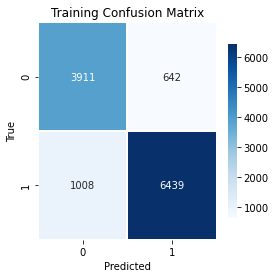

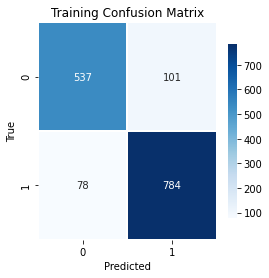

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times00

  vgg16.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # pbar = tqdm(enumerate(trainloader))
  train_p=[]
  train_l=[]

  for i, data in enumerate(trainloader, 0):

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = vgg16(inputs)               #----> forward pass
    _, predicted = torch.max(outputs.data, 1)

    loss = criterion(outputs, labels)   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    total_correct += get_num_correct(outputs, labels)
    

    train_p.extend(predicted.cpu().numpy())
    train_l.extend(labels.cpu().numpy())
    
  

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss)
  torch.save(vgg16,"vgg16_FC_Only_diff_1000_LR.pth")

  vgg16.eval()
  from sklearn.metrics import confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = vgg16(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          loss = criterion(outputs, labels)
          running_loss += loss.item()

          valid_p.extend(predicted.cpu().numpy())
          valid_l.extend(labels.cpu().numpy())

  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss)
  print(" ")












#   # torch.save(vgg16, 'vgg16_FC_Only.pth')
#     # pbar.set_description(
#     #     'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#     #         epoch, i * len(inputs), len(trainloader.dataset),
#     #         100. * i / len(trainloader),
#     #         loss.data.item()))
    
#   # 


# torch.save(vgg16.state_dict(), 'vgg16_ft.pth')

print("Training Accuracy",a,"%")

print("Validation Accuracy",((100 * correct) / total),"%")

print('Finished Training')



plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)

import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()


# Testing Vgg16 with Lr= 0.0001

In [0]:
vgg16=torch.load("vgg16_FC_Only_diff_1000_LR.pth")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Accuracy of the network on the test images: 94 %


Text(0.5, 1.0, 'Testing Confusion Matrix')

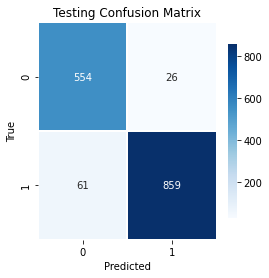

In [0]:
from sklearn.metrics import confusion_matrix
correct = 0
total = 0
p=[]
l=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        p.extend(predicted.cpu().numpy())
        l.extend(labels.cpu().numpy())

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))


# p=np.array(p)
# l=np.array(l)
input=confusion_matrix(p,l)
# print 'Confusion Matrix :'
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(input,cmap="Blues", annot=True,fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix")
# ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=22)
# ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=22)

# Load Vgg16 and set FC to ((63*10)+100)


In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True,progress=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
features = list(vgg16.classifier.children())[:-7] # Remove last FC layers
features

[]

In [0]:
for para in vgg16.features.parameters():
  para.require_grad=False
  # print(para.require_grad)

for k in vgg16.features.parameters():
  k.requires_grad=False

  # print(k.requires_grad)
  

In [0]:
features.extend([nn.Linear(in_features=25088,out_features=630+100,bias=True)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5,inplace=False)])
features.extend([nn.Linear(in_features=630+100,out_features=2,bias=False)])
features

vgg16.classifier=nn.Sequential(*features)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)


Train: epoch:  0 total_correct:  9705.0 total_loss:  80.33851557970047
Valid: epoch:  0 total_correct:  1298 total_loss:  7.810395985841751
 
Train: epoch:  1 total_correct:  10276.0 total_loss:  64.94328604638577
Valid: epoch:  1 total_correct:  1308 total_loss:  7.451126247644424
 
Train: epoch:  2 total_correct:  10354.0 total_loss:  62.57049572467804
Valid: epoch:  2 total_correct:  1324 total_loss:  7.089169017970562
 
Train: epoch:  3 total_correct:  10421.0 total_loss:  60.02254359424114
Valid: epoch:  3 total_correct:  1321 total_loss:  7.253181517124176
 
Train: epoch:  4 total_correct:  10441.0 total_loss:  59.58361414074898
Valid: epoch:  4 total_correct:  1327 total_loss:  7.034399136900902
 
Train: epoch:  5 total_correct:  10434.0 total_loss:  58.44516336917877
Valid: epoch:  5 total_correct:  1330 total_loss:  7.230271011590958
 
Train: epoch:  6 total_correct:  10514.0 total_loss:  57.1889092028141
Valid: epoch:  6 total_correct:  1327 total_loss:  6.919391393661499
 
T

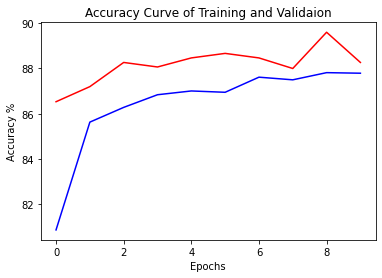

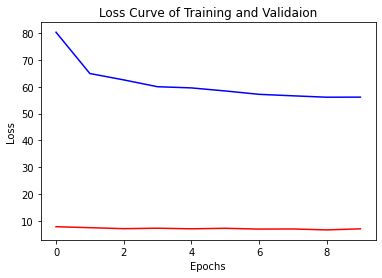

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


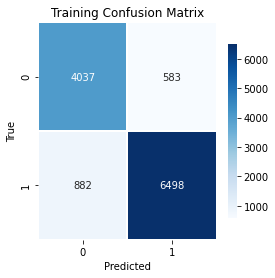

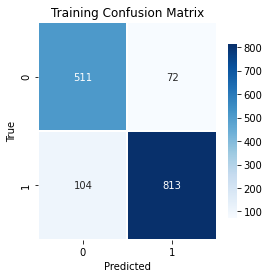

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times00

  vgg16.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # pbar = tqdm(enumerate(trainloader))
  train_p=[]
  train_l=[]

  for i, data in enumerate(trainloader, 0):

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = vgg16(inputs)               #----> forward pass
    _, predicted = torch.max(outputs.data, 1)

    loss = criterion(outputs, labels)   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    total_correct += get_num_correct(outputs, labels)
    

    train_p.extend(predicted.cpu().numpy())
    train_l.extend(labels.cpu().numpy())
    
  

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss)
  torch.save(vgg16,"vgg16_FC_Only.pth")

  vgg16.eval()
  from sklearn.metrics import confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = vgg16(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          loss = criterion(outputs, labels)
          running_loss += loss.item()

          valid_p.extend(predicted.cpu().numpy())
          valid_l.extend(labels.cpu().numpy())

  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss)
  print(" ")

print("Training Accuracy",a,"%")
print("Validation Accuracy",((100 * correct) / total),"%")
print('Finished Training')

plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)

import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()


## Testing vgg16 FC=(63*10)+100





In [0]:
vgg16=torch.load("vgg16_FC_Only.pth")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Accuracy of the network on the test images: 94 %
F1 Score : 0.9559471365638766


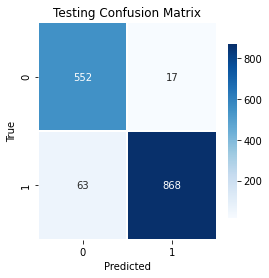

In [0]:
from sklearn.metrics import confusion_matrix
correct = 0
total = 0
p=[]
l=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        p.extend(predicted.cpu().numpy())
        l.extend(labels.cpu().numpy())

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))


# p=np.array(p)
# l=np.array(l)
input=confusion_matrix(p,l)
# print 'Confusion Matrix :'
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(input,cmap="Blues", annot=True,fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix")
# ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=22)
# ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=22)
from sklearn.metrics import f1_score

print("F1 Score :",f1_score(l, p)) # p are predicted labels and l are true labels



## **Load Resnet-50 and Fine Tune**
# **Train Resnet on Lr = 0.001**


```
# This is formatted as code

> Indented block


```



In [0]:
resnet18=models.resnet18(pretrained=True, progress=True)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:

for param in resnet18.parameters():
  
  param.requires_grad=False
  param.require_grad=False
  
  print(param.requires_grad)

In [0]:

features=[]
features.extend([nn.Linear(in_features=512,out_features=630+100,bias=True)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5,inplace=False)])
features.extend([nn.Linear(in_features=630+100,out_features=2,bias=False)])
resnet18.fc=nn.Sequential(*features)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)


Train Epoch: 0 [5984/12000 (99%)]	Loss: 0.308338: : 188it [04:12,  1.34s/it]


Train: epoch:  0 total_correct:  9008.0 total_loss:  96.22260266542435
Valid: epoch:  0 total_correct:  1226 total_loss:  9.868193432688713
 


Train Epoch: 1 [5984/12000 (99%)]	Loss: 0.584542: : 188it [05:54,  1.89s/it]


Train: epoch:  1 total_correct:  9783.0 total_loss:  80.25539049506187
Valid: epoch:  1 total_correct:  1244 total_loss:  9.211739927530289
 


Train Epoch: 2 [5984/12000 (99%)]	Loss: 0.351948: : 188it [06:12,  1.98s/it]


Train: epoch:  2 total_correct:  9921.0 total_loss:  75.8809879720211
Valid: epoch:  2 total_correct:  1260 total_loss:  8.944302141666412
 


Train Epoch: 3 [5984/12000 (99%)]	Loss: 0.461937: : 188it [05:54,  1.88s/it]


Train: epoch:  3 total_correct:  9981.0 total_loss:  73.42219445109367
Valid: epoch:  3 total_correct:  1271 total_loss:  8.878033638000488
 


Train Epoch: 4 [5984/12000 (99%)]	Loss: 0.349294: : 188it [05:55,  1.89s/it]


Train: epoch:  4 total_correct:  10029.0 total_loss:  71.41526173055172
Valid: epoch:  4 total_correct:  1267 total_loss:  8.767836317420006
 


Train Epoch: 5 [5984/12000 (99%)]	Loss: 0.420766: : 188it [06:20,  2.02s/it]


Train: epoch:  5 total_correct:  10037.0 total_loss:  70.48381312191486
Valid: epoch:  5 total_correct:  1275 total_loss:  8.611543014645576
 


Train Epoch: 6 [5984/12000 (99%)]	Loss: 0.503354: : 188it [05:51,  1.87s/it]


Train: epoch:  6 total_correct:  10083.0 total_loss:  71.35742495954037
Valid: epoch:  6 total_correct:  1276 total_loss:  8.677023977041245
 


Train Epoch: 7 [5984/12000 (99%)]	Loss: 0.267333: : 188it [07:16,  2.32s/it]


Train: epoch:  7 total_correct:  10100.0 total_loss:  69.54100592434406
Valid: epoch:  7 total_correct:  1282 total_loss:  8.489625036716461
 


Train Epoch: 8 [5984/12000 (99%)]	Loss: 0.487200: : 188it [06:41,  2.13s/it]


Train: epoch:  8 total_correct:  10131.0 total_loss:  69.67233294248581
Valid: epoch:  8 total_correct:  1281 total_loss:  8.610851302742958
 


Train Epoch: 9 [5984/12000 (99%)]	Loss: 0.402885: : 188it [06:14,  1.99s/it]


Train: epoch:  9 total_correct:  10157.0 total_loss:  69.12868157029152
Valid: epoch:  9 total_correct:  1279 total_loss:  8.59760183095932
 
Training Accuracy 84.64166666666667 %
Validation Accuracy 85.26666666666667 %
Finished Training


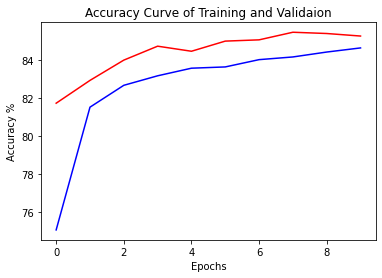

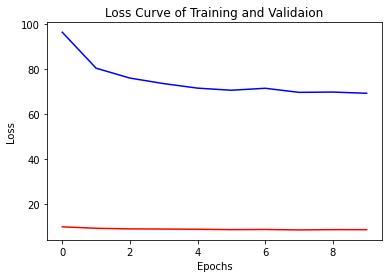

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


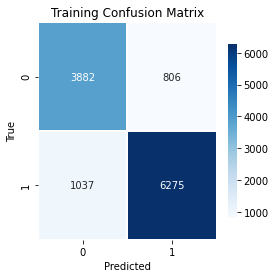

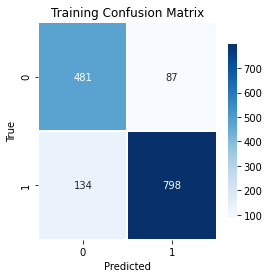

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times00

  resnet18.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # pbar = tqdm(enumerate(trainloader))
  train_p=[]
  train_l=[]
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = resnet18(inputs)               #----> forward pass
    _, predicted = torch.max(outputs.data, 1)

    loss = criterion(outputs, labels)   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    total_correct += get_num_correct(outputs, labels)
    

    train_p.extend(predicted.cpu().numpy())
    train_l.extend(labels.cpu().numpy())
    
    pbar.set_description(
              'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, i * len(inputs), len(trainloader.dataset),
                  100. * i / len(trainloader),
                  loss.data.item()))

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss)
  torch.save(resnet18,"res18_FC_Only.pth")

  resnet18.eval()
  from sklearn.metrics import confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = resnet18(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          loss = criterion(outputs, labels)
          running_loss += loss.item()

          valid_p.extend(predicted.cpu().numpy())
          valid_l.extend(labels.cpu().numpy())

  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss)
  print(" ")

print("Training Accuracy",a,"%")
print("Validation Accuracy",((100 * correct) / total),"%")
print('Finished Training')

plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)

import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()


In [0]:
resnet18=torch.load("res18_FC_Only.pth")

resnet18.eval()
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# resnet18.to(device)
# # resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Accuracy of the Resnet-18 on the test images: 92 %
F1 Score : 0.9345794392523364


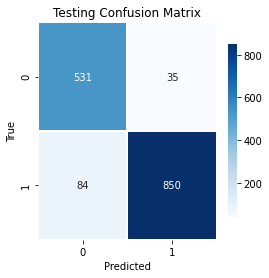

In [0]:
from sklearn.metrics import confusion_matrix
correct = 0
total = 0
p=[]
l=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        p.extend(predicted.cpu().numpy())
        l.extend(labels.cpu().numpy())

print('Accuracy of the Resnet-18 on the test images: %d %%' % (
    100 * correct / total))


# p=np.array(p)
# l=np.array(l)
input=confusion_matrix(p,l)
# print 'Confusion Matrix :'
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(input,cmap="Blues", annot=True,fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix")
# ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=22)
# ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=22)

from sklearn.metrics import f1_score

print("F1 Score :",f1_score(l, p)) # p are predicted labels and l are true labels


# **Train Resnet18 with LR=0.0001**

Load model

In [0]:
resnet18=models.resnet18(pretrained=True, progress=True)
print("hi")

for param in resnet18.parameters():
  
  param.requires_grad=False
  param.require_grad=False


features=[]
features.extend([nn.Linear(in_features=512,out_features=630+100,bias=True)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5,inplace=False)])
features.extend([nn.Linear(in_features=630+100,out_features=2,bias=False)])
resnet18.fc=nn.Sequential(*features)
resnet18

hi


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Train Model

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.0001, momentum=0.9)


In [0]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
# vg.train(mode=True)

cuda:0


Train Epoch: 0 [8928/12000 (99%)]	Loss: 0.635274: : 94it [28:24, 18.14s/it]


Train: epoch:  0 total_correct:  7074.0 total_loss:  62.99946177005768
Valid: epoch:  0 total_correct:  930 total_loss:  7.426272690296173
 


Train Epoch: 1 [8928/12000 (99%)]	Loss: 0.610572: : 94it [04:15,  2.71s/it]


Train: epoch:  1 total_correct:  7862.0 total_loss:  58.692769289016724
Valid: epoch:  1 total_correct:  1017 total_loss:  6.9153284430503845
 


Train Epoch: 2 [8928/12000 (99%)]	Loss: 0.579488: : 94it [04:15,  2.72s/it]


Train: epoch:  2 total_correct:  8421.0 total_loss:  55.12764382362366
Valid: epoch:  2 total_correct:  1138 total_loss:  6.506278157234192
 


Train Epoch: 3 [8928/12000 (99%)]	Loss: 0.549570: : 94it [04:17,  2.74s/it]


Train: epoch:  3 total_correct:  8740.0 total_loss:  52.62060338258743
Valid: epoch:  3 total_correct:  1146 total_loss:  6.199399709701538
 


Train Epoch: 4 [8928/12000 (99%)]	Loss: 0.527030: : 94it [04:16,  2.73s/it]


Train: epoch:  4 total_correct:  9005.0 total_loss:  51.15091449022293
Valid: epoch:  4 total_correct:  1174 total_loss:  5.966360360383987
 


Train Epoch: 5 [8928/12000 (99%)]	Loss: 0.605087: : 94it [04:16,  2.73s/it]


Train: epoch:  5 total_correct:  9213.0 total_loss:  49.356562197208405
Valid: epoch:  5 total_correct:  1185 total_loss:  5.787000983953476
 


Train Epoch: 6 [8928/12000 (99%)]	Loss: 0.478374: : 94it [04:18,  2.75s/it]


Train: epoch:  6 total_correct:  9278.0 total_loss:  47.955303996801376
Valid: epoch:  6 total_correct:  1194 total_loss:  5.610150903463364
 


Train Epoch: 7 [8928/12000 (99%)]	Loss: 0.476971: : 94it [04:17,  2.74s/it]


Train: epoch:  7 total_correct:  9310.0 total_loss:  47.02917295694351
Valid: epoch:  7 total_correct:  1211 total_loss:  5.485137552022934
 


Train Epoch: 8 [8928/12000 (99%)]	Loss: 0.494724: : 94it [04:16,  2.73s/it]


Train: epoch:  8 total_correct:  9513.0 total_loss:  45.204761415719986
Valid: epoch:  8 total_correct:  1212 total_loss:  5.40444278717041
 


Train Epoch: 9 [8928/12000 (99%)]	Loss: 0.502947: : 94it [04:25,  2.82s/it]


Train: epoch:  9 total_correct:  9498.0 total_loss:  45.074474543333054
Valid: epoch:  9 total_correct:  1212 total_loss:  5.3042424619197845
 
Training Accuracy 79.15 %
Validation Accuracy 80.8 %
Finished Training


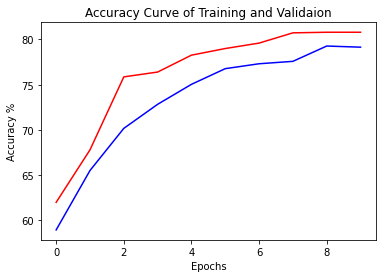

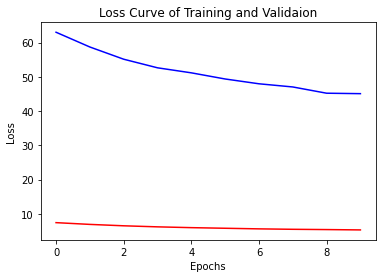

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


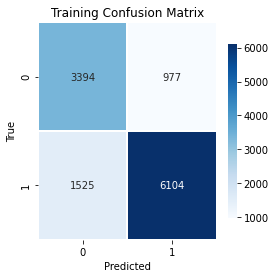

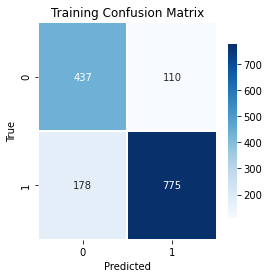

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)
print(device)
train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times00

  resnet18.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # pbar = tqdm(enumerate(trainloader))
  train_p=[]
  train_l=[]
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = resnet18(inputs)               #----> forward pass
    _, predicted = torch.max(outputs.data, 1)

    loss = criterion(outputs, labels)   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    total_correct += get_num_correct(outputs, labels)
    

    train_p.extend(predicted.cpu().numpy())
    train_l.extend(labels.cpu().numpy())
    
    pbar.set_description(
              'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, i * len(inputs), len(trainloader.dataset),
                  100. * i / len(trainloader),
                  loss.data.item()))

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss)
  torch.save(resnet18,"res18_FC_Only_LR_0001.pth")

  resnet18.eval()
  from sklearn.metrics import confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = resnet18(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          loss = criterion(outputs, labels)
          running_loss += loss.item()

          valid_p.extend(predicted.cpu().numpy())
          valid_l.extend(labels.cpu().numpy())

  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss)
  print(" ")

print("Training Accuracy",a,"%")
print("Validation Accuracy",((100 * correct) / total),"%")
print('Finished Training')

plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)

import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()


Test Resnet-18

In [0]:
resnet18=torch.load("res18_FC_Only_LR_0001.pth")

resnet18.eval()
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# resnet18.to(device)
# # resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Accuracy of the Resnet-18 on the test images: 87 %
F1 Score : 0.898550724637681


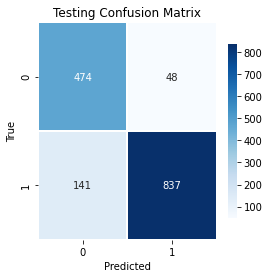

In [0]:
from sklearn.metrics import confusion_matrix
correct = 0
total = 0
p=[]
l=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        p.extend(predicted.cpu().numpy())
        l.extend(labels.cpu().numpy())

print('Accuracy of the Resnet-18 on the test images: %d %%' % (
    100 * correct / total))


# p=np.array(p)
# l=np.array(l)
input=confusion_matrix(p,l)
# print 'Confusion Matrix :'
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(input,cmap="Blues", annot=True,fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix")
# ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=22)
# ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=22)

from sklearn.metrics import f1_score

print("F1 Score :",f1_score(l, p)) # p are predicted labels and l are true labels


# ***`TASK # 2`***

> Indented block



# ***Fine Tune VGG16 ***

*   Load Model

```
# This is formatted as code
```


*   Fine Tuning
*   Training Loop
*   Testing Loop







In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
features = list(vgg16.classifier.children())[:-7] # Remove last FC layers
features

[]

In [0]:
features.extend([nn.Linear(in_features=25088,out_features=630+100,bias=True)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5,inplace=False)])
features.extend([nn.Linear(in_features=630+100,out_features=2,bias=False)])

In [0]:
vgg16.classifier=nn.Sequential(*features)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Train *VGG16*

In [0]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
# vg.train(mode=True)

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)


Train Epoch: 0 [8928/12000 (99%)]	Loss: 0.367216: : 94it [06:18,  4.02s/it]


Train: epoch:  0 total_correct:  9735.0 total_loss:  38.821400344371796
Valid: epoch:  0 total_correct:  1327 total_loss:  3.3228876888751984
 


Train Epoch: 1 [8928/12000 (99%)]	Loss: 0.283750: : 94it [04:48,  3.07s/it]


Train: epoch:  1 total_correct:  10641.0 total_loss:  26.69486014544964
Valid: epoch:  1 total_correct:  1338 total_loss:  2.999987930059433
 


Train Epoch: 2 [8928/12000 (99%)]	Loss: 0.354870: : 94it [04:46,  3.05s/it]


Train: epoch:  2 total_correct:  10848.0 total_loss:  23.560651496052742
Valid: epoch:  2 total_correct:  1358 total_loss:  2.8278146535158157
 


Train Epoch: 3 [8928/12000 (99%)]	Loss: 0.281814: : 94it [04:48,  3.06s/it]


Train: epoch:  3 total_correct:  10855.0 total_loss:  23.06294532865286
Valid: epoch:  3 total_correct:  1365 total_loss:  2.6910480558872223
 


Train Epoch: 4 [8928/12000 (99%)]	Loss: 0.177971: : 94it [04:52,  3.11s/it]


Train: epoch:  4 total_correct:  10844.0 total_loss:  23.003518670797348
Valid: epoch:  4 total_correct:  1333 total_loss:  2.9463850557804108
 


Train Epoch: 5 [8928/12000 (99%)]	Loss: 0.259781: : 94it [04:50,  3.10s/it]


Train: epoch:  5 total_correct:  10899.0 total_loss:  21.959558978676796
Valid: epoch:  5 total_correct:  1365 total_loss:  2.84262116253376
 


Train Epoch: 6 [8928/12000 (99%)]	Loss: 0.132074: : 94it [04:51,  3.10s/it]


Train: epoch:  6 total_correct:  10936.0 total_loss:  21.19740203768015
Valid: epoch:  6 total_correct:  1370 total_loss:  2.6068805679678917
 


Train Epoch: 7 [8928/12000 (99%)]	Loss: 0.173024: : 94it [04:51,  3.10s/it]


Train: epoch:  7 total_correct:  11021.0 total_loss:  20.02807155251503
Valid: epoch:  7 total_correct:  1365 total_loss:  2.713943287730217
 


Train Epoch: 8 [8928/12000 (99%)]	Loss: 0.147980: : 94it [04:41,  3.00s/it]


Train: epoch:  8 total_correct:  10988.0 total_loss:  19.977537468075752
Valid: epoch:  8 total_correct:  1367 total_loss:  2.6189075112342834
 


Train Epoch: 9 [8928/12000 (99%)]	Loss: 0.171255: : 94it [04:40,  2.99s/it]


Train: epoch:  9 total_correct:  11007.0 total_loss:  20.058066681027412
Valid: epoch:  9 total_correct:  1372 total_loss:  2.564315512776375
 
Training Accuracy 91.725 %
Validation Accuracy 91.46666666666667 %
Finished Training


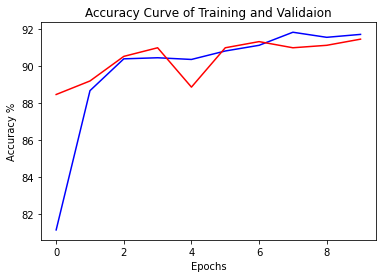

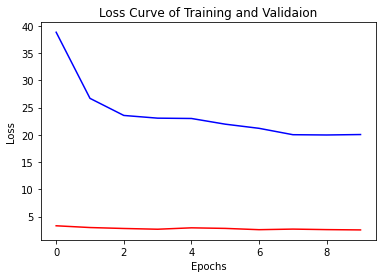

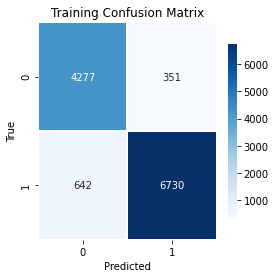

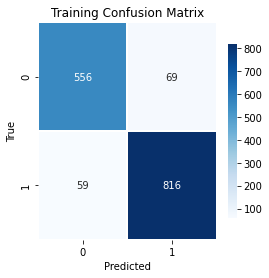

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

  vgg16.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # 
  train_p=[]
  train_l=[]
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = vgg16(inputs)               #----> forward pass
    _, predicted = torch.max(outputs.data, 1)

    loss = criterion(outputs, labels)   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    total_correct += get_num_correct(outputs, labels)
    

    train_p.extend(predicted.cpu().numpy())
    train_l.extend(labels.cpu().numpy())
    pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
  

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss)
  torch.save(vgg16,"vgg16_entire.pth")

  vgg16.eval()
  from sklearn.metrics import confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = vgg16(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          loss = criterion(outputs, labels)
          running_loss += loss.item()

          valid_p.extend(predicted.cpu().numpy())
          valid_l.extend(labels.cpu().numpy())

  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss)
  print(" ")

print("Training Accuracy",a,"%")

print("Validation Accuracy",((100 * correct) / total),"%")

print('Finished Training')



plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)

import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()


Testing

In [0]:
vgg16=torch.load("vgg16_entire.pth")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Accuracy of the network on the test images: 97 %
F1 Score : 0.9775784753363229


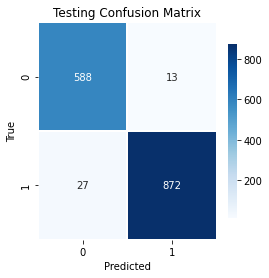

In [0]:
from sklearn.metrics import confusion_matrix
correct = 0
total = 0
p=[]
l=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        p.extend(predicted.cpu().numpy())
        l.extend(labels.cpu().numpy())

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))


# p=np.array(p)
# l=np.array(l)
input=confusion_matrix(p,l)
# print 'Confusion Matrix :'
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(input,cmap="Blues", annot=True,fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix")
# ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=22)
# ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=22)

from sklearn.metrics import f1_score

print("F1 Score :",f1_score(l, p)) # p are predicted labels and l are true labels


# **Fine_Tune Resnet-18 (All Unfreeze)**




*   Load Model
*   Fine Tuning
*   Training Loop
*   Testing Loop
*



# Open it...




In [0]:
resnet18=models.resnet18(pretrained=True, progress=True)
print("hi")


features=[]
features.extend([nn.Linear(in_features=512,out_features=630+100,bias=True)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5,inplace=False)])
features.extend([nn.Linear(in_features=630+100,out_features=2,bias=False)])
resnet18.fc=nn.Sequential(*features)
resnet18

hi


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
for p in resnet18.parameters():
  print(p.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)


In [0]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
# vg.train(mode=True)

cuda:0


Train Epoch: 0 [5984/12000 (99%)]	Loss: 0.274172: : 188it [04:08,  1.32s/it]


Train: epoch:  0 total_correct:  9715.0 total_loss:  78.33523640036583
Valid: epoch:  0 total_correct:  1323 total_loss:  6.9841446578502655
 


Train Epoch: 1 [5984/12000 (99%)]	Loss: 0.128934: : 188it [04:13,  1.35s/it]


Train: epoch:  1 total_correct:  10627.0 total_loss:  54.028040178120136
Valid: epoch:  1 total_correct:  1335 total_loss:  6.385824106633663
 


Train Epoch: 2 [5984/12000 (99%)]	Loss: 0.233222: : 188it [04:10,  1.33s/it]


Train: epoch:  2 total_correct:  10729.0 total_loss:  50.039811328053474
Valid: epoch:  2 total_correct:  1341 total_loss:  6.265066012740135
 


Train Epoch: 3 [5984/12000 (99%)]	Loss: 0.324334: : 188it [04:16,  1.37s/it]


Train: epoch:  3 total_correct:  10781.0 total_loss:  47.427007518708706
Valid: epoch:  3 total_correct:  1344 total_loss:  6.14963786303997
 


Train Epoch: 4 [5984/12000 (99%)]	Loss: 0.413080: : 188it [04:14,  1.35s/it]


Train: epoch:  4 total_correct:  10887.0 total_loss:  44.99937102943659
Valid: epoch:  4 total_correct:  1346 total_loss:  5.965260177850723
 


Train Epoch: 5 [5984/12000 (99%)]	Loss: 0.240150: : 188it [04:10,  1.33s/it]


Train: epoch:  5 total_correct:  10889.0 total_loss:  44.60442790389061
Valid: epoch:  5 total_correct:  1336 total_loss:  6.756973713636398
 


Train Epoch: 6 [5984/12000 (99%)]	Loss: 0.196731: : 188it [04:05,  1.31s/it]


Train: epoch:  6 total_correct:  10864.0 total_loss:  43.57632330805063
Valid: epoch:  6 total_correct:  1335 total_loss:  6.09876424074173
 


Train Epoch: 7 [5984/12000 (99%)]	Loss: 0.389834: : 188it [04:02,  1.29s/it]


Train: epoch:  7 total_correct:  10919.0 total_loss:  42.21704915165901
Valid: epoch:  7 total_correct:  1347 total_loss:  5.789218194782734
 


Train Epoch: 8 [5984/12000 (99%)]	Loss: 0.114799: : 188it [04:09,  1.33s/it]


Train: epoch:  8 total_correct:  10962.0 total_loss:  40.70415787026286
Valid: epoch:  8 total_correct:  1361 total_loss:  5.5668248906731606
 


Train Epoch: 9 [5984/12000 (99%)]	Loss: 0.140086: : 188it [04:14,  1.35s/it]


Train: epoch:  9 total_correct:  11006.0 total_loss:  40.55289138108492
Valid: epoch:  9 total_correct:  1346 total_loss:  5.5754750072956085
 
Training Accuracy 91.71666666666667 %
Validation Accuracy 89.73333333333333 %
Finished Training


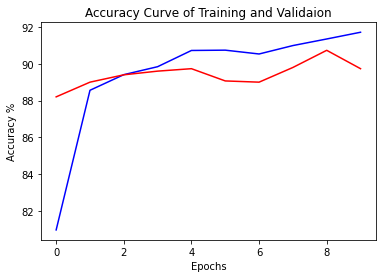

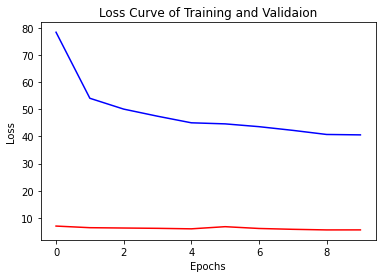

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


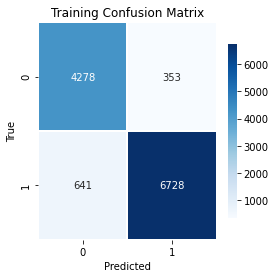

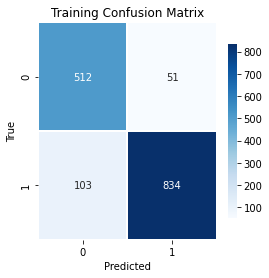

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)
print(device)
train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times00

  resnet18.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # pbar = tqdm(enumerate(trainloader))
  train_p=[]
  train_l=[]
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = resnet18(inputs)               #----> forward pass
    _, predicted = torch.max(outputs.data, 1)

    loss = criterion(outputs, labels)   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    total_correct += get_num_correct(outputs, labels)
    

    train_p.extend(predicted.cpu().numpy())
    train_l.extend(labels.cpu().numpy())
    
    pbar.set_description(
              'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, i * len(inputs), len(trainloader.dataset),
                  100. * i / len(trainloader),
                  loss.data.item()))

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss)
  torch.save(resnet18,"res18_entire.pth")

  resnet18.eval()
  from sklearn.metrics import confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = resnet18(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          loss = criterion(outputs, labels)
          running_loss += loss.item()

          valid_p.extend(predicted.cpu().numpy())
          valid_l.extend(labels.cpu().numpy())

  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss)
  print(" ")

print("Training Accuracy",a,"%")
print("Validation Accuracy",((100 * correct) / total),"%")
print('Finished Training')

plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)

import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()


Testing


In [0]:
resnet18=torch.load("res18_entire.pth")

resnet18.eval()
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# resnet18.to(device)
# # resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Accuracy of the Resnet-18 on the test images: 96 %
F1 Score : 0.9690607734806629


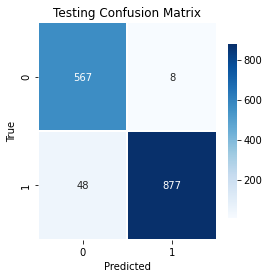

In [0]:
from sklearn.metrics import confusion_matrix
correct = 0
total = 0
p=[]
l=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        p.extend(predicted.cpu().numpy())
        l.extend(labels.cpu().numpy())

print('Accuracy of the Resnet-18 on the test images: %d %%' % (
    100 * correct / total))


# p=np.array(p)
# l=np.array(l)
input=confusion_matrix(p,l)
# print 'Confusion Matrix :'
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(input,cmap="Blues", annot=True,fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix")
# ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=22)
# ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=22)

from sklearn.metrics import f1_score

print("F1 Score :",f1_score(l, p)) # p are predicted labels and l are true labels


# Train VGG16 Unfreeze last 3 convolutions and FC layer

---



In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True,progress=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
features = list(vgg16.classifier.children())[:-7] # Remove last FC layers
features
for para in vgg16.features.parameters():
  para.require_grad=False
  # print(para.require_grad)

for k in vgg16.features.parameters():
  k.requires_grad=False
    

  # print(k.requires_grad)
  

In [0]:
features.extend([nn.Linear(in_features=25088,out_features=630+100,bias=True)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5,inplace=False)])
features.extend([nn.Linear(in_features=630+100,out_features=2,bias=False)])
features

vgg16.classifier=nn.Sequential(*features)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Freeze last 3 features convolution layers

In [0]:

# Freeze last 3 features convolution layers

for n,k in vgg16.named_parameters():
  if(n == 'features.24.weight' or n == 'features.24.bias'):
    k.requires_grad = True
  if(n == 'features.26.weight' or n == 'features.26.bias'):
    k.requires_grad = True
  if(n == 'features.28.weight' or n == 'features.28.bias'):
    k.requires_grad = True

  print(n, k.requires_grad)

for param in vgg16.parameters():
  print(counter,param.requires_grad)
  counter+=1 


features.0.weight False
features.0.bias False
features.2.weight False
features.2.bias False
features.5.weight False
features.5.bias False
features.7.weight False
features.7.bias False
features.10.weight False
features.10.bias False
features.12.weight False
features.12.bias False
features.14.weight False
features.14.bias False
features.17.weight False
features.17.bias False
features.19.weight False
features.19.bias False
features.21.weight False
features.21.bias False
features.24.weight True
features.24.bias True
features.26.weight True
features.26.bias True
features.28.weight True
features.28.bias True
classifier.0.weight True
classifier.0.bias True
classifier.3.weight True
0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 True
21 True
22 True
23 True
24 True
25 True
26 True
27 True
28 True


Training Loop

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0x .001, momentum=0.9)


In [0]:

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
# vg.train(mode=True)

Train Epoch: 0 [5984/12000 (99%)]	Loss: 0.248247: : 188it [05:09,  1.65s/it]


Train: epoch:  0 total_correct:  9878.0 total_loss:  73.99263779819012
Valid: epoch:  0 total_correct:  1302 total_loss:  7.324694409966469
 


Train Epoch: 1 [5984/12000 (99%)]	Loss: 0.310420: : 188it [04:14,  1.36s/it]


Train: epoch:  1 total_correct:  10583.0 total_loss:  55.09269444644451
Valid: epoch:  1 total_correct:  1340 total_loss:  5.991896241903305
 


Train Epoch: 2 [5984/12000 (99%)]	Loss: 0.377000: : 188it [04:14,  1.35s/it]


Train: epoch:  2 total_correct:  10686.0 total_loss:  50.34002769738436
Valid: epoch:  2 total_correct:  1345 total_loss:  5.931286029517651
 


Train Epoch: 3 [5984/12000 (99%)]	Loss: 0.273830: : 188it [04:13,  1.35s/it]


Train: epoch:  3 total_correct:  10768.0 total_loss:  49.12470235675573
Valid: epoch:  3 total_correct:  1353 total_loss:  5.822480946779251
 


Train Epoch: 4 [5984/12000 (99%)]	Loss: 0.295253: : 188it [04:09,  1.33s/it]


Train: epoch:  4 total_correct:  10830.0 total_loss:  46.278339482843876
Valid: epoch:  4 total_correct:  1351 total_loss:  5.648000419139862
 


Train Epoch: 5 [5984/12000 (99%)]	Loss: 0.144293: : 188it [04:06,  1.31s/it]


Train: epoch:  5 total_correct:  10821.0 total_loss:  46.19477266818285
Valid: epoch:  5 total_correct:  1350 total_loss:  5.6296499744057655
 


Train Epoch: 6 [5984/12000 (99%)]	Loss: 0.210902: : 188it [04:05,  1.31s/it]


Train: epoch:  6 total_correct:  10898.0 total_loss:  44.11352930217981
Valid: epoch:  6 total_correct:  1338 total_loss:  5.7733234614133835
 


Train Epoch: 7 [5984/12000 (99%)]	Loss: 0.280037: : 188it [04:05,  1.30s/it]


Train: epoch:  7 total_correct:  10912.0 total_loss:  43.7268450409174
Valid: epoch:  7 total_correct:  1355 total_loss:  5.7933672815561295
 


Train Epoch: 8 [5984/12000 (99%)]	Loss: 0.249224: : 188it [04:02,  1.29s/it]


Train: epoch:  8 total_correct:  10914.0 total_loss:  42.810393273830414
Valid: epoch:  8 total_correct:  1322 total_loss:  6.7581656612455845
 


Train Epoch: 9 [5984/12000 (99%)]	Loss: 0.214001: : 188it [04:02,  1.29s/it]


Train: epoch:  9 total_correct:  10936.0 total_loss:  42.88525426387787
Valid: epoch:  9 total_correct:  1348 total_loss:  5.4159019365906715
 
Training Accuracy 91.13333333333334 %
Validation Accuracy 89.86666666666666 %
Finished Training


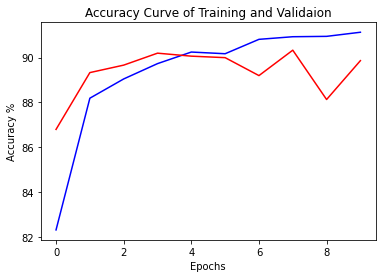

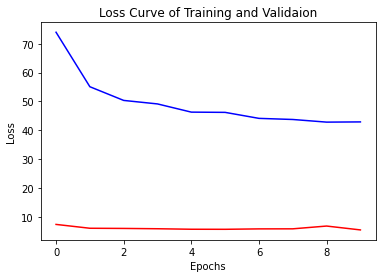

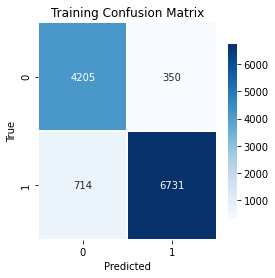

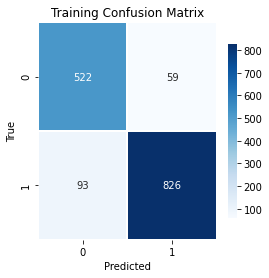

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

  vgg16.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # 
  train_p=[]
  train_l=[]
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = vgg16(inputs)               #----> forward pass
    _, predicted = torch.max(outputs.data, 1)

    loss = criterion(outputs, labels)   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    total_correct += get_num_correct(outputs, labels)
    

    train_p.extend(predicted.cpu().numpy())
    train_l.extend(labels.cpu().numpy())
    pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
  

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss)
  torch.save(vgg16,"vgg16_FC_Last3Conv.pth")

  vgg16.eval()
  from sklearn.metrics import confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = vgg16(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          loss = criterion(outputs, labels)
          running_loss += loss.item()

          valid_p.extend(predicted.cpu().numpy())
          valid_l.extend(labels.cpu().numpy())

  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss)
  print(" ")

print("Training Accuracy",a,"%")

print("Validation Accuracy",((100 * correct) / total),"%")

print('Finished Training')



plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)

import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()


Testing Loop

In [0]:
vgg16=torch.load("vgg16_FC_Last3Conv.pth")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Accuracy of the network on the test images: 96 %
F1 Score : 0.9722530521642619


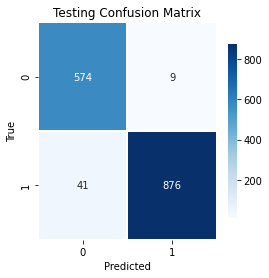

In [0]:

from sklearn.metrics import confusion_matrix
correct = 0
total = 0
p=[]
l=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        p.extend(predicted.cpu().numpy())
        l.extend(labels.cpu().numpy())

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))


# p=np.array(p)
# l=np.array(l)
input=confusion_matrix(p,l)
# print 'Confusion Matrix :'
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(input,cmap="Blues", annot=True,fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix")
# ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=22)
# ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=22)

from sklearn.metrics import f1_score

print("F1 Score :",f1_score(l, p)) # p are predicted labels and l are true labels


# Train Resnet18 Unfreeze last convolution and FC **layer**

```
# This is formatted as code
```




In [0]:
resnet18=models.resnet18(pretrained=True, progress=True)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:

for param in resnet18.parameters():
  
  param.requires_grad=False
  param.require_grad=False

In [0]:
features=[]
features.extend([nn.Linear(in_features=512,out_features=630+100,bias=True)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5,inplace=False)])
features.extend([nn.Linear(in_features=630+100,out_features=2,bias=False)])
resnet18.fc=nn.Sequential(*features)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
for param in resnet18.layer4.parameters():
  param.requires_grad=True


for n,k in resnet18.named_parameters():
  print(n,k.requires_grad)

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2.bias False
layer2.0.downsample.0.weight False
layer2.0.downsample.1.weight False
layer2.0.downsample.1.bias False
layer2.1.conv1.weight False
layer2.1.bn1.weight False
layer2.1.bn1.bias False
layer2.1.conv2.weight False
layer2.1.bn2.weight False
layer2.1.bn2.bias False
layer3.0.conv1.weight False
layer3.0.bn1.weight False
layer3.0.bn1.bias False
layer3.0.conv2.weight False
layer3.0.bn2.weight False
layer3.0.bn2.bias False
layer3.0.downsample.0.weight False
layer3.0.downsample.1.weight Fa

Training Loop . . .

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)


In [0]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
# vg.train(mode=True)

Train Epoch: 0 [5984/12000 (99%)]	Loss: 0.285661: : 188it [18:50,  6.01s/it]


Train: epoch:  0 total_correct:  9427.0 total_loss:  86.34832617640495
Valid: epoch:  0 total_correct:  1287 total_loss:  8.48120342195034
 


Train Epoch: 1 [5984/12000 (99%)]	Loss: 0.279006: : 188it [04:27,  1.42s/it]


Train: epoch:  1 total_correct:  10399.0 total_loss:  62.211551412940025
Valid: epoch:  1 total_correct:  1310 total_loss:  7.430265665054321
 


Train Epoch: 2 [5984/12000 (99%)]	Loss: 0.163329: : 188it [04:25,  1.41s/it]


Train: epoch:  2 total_correct:  10523.0 total_loss:  56.625632762908936
Valid: epoch:  2 total_correct:  1317 total_loss:  7.20877979695797
 


Train Epoch: 3 [5984/12000 (99%)]	Loss: 0.272218: : 188it [04:28,  1.43s/it]


Train: epoch:  3 total_correct:  10578.0 total_loss:  54.09439939260483
Valid: epoch:  3 total_correct:  1334 total_loss:  7.135469749569893
 


Train Epoch: 4 [5984/12000 (99%)]	Loss: 0.273633: : 188it [04:26,  1.42s/it]


Train: epoch:  4 total_correct:  10633.0 total_loss:  52.112751960754395
Valid: epoch:  4 total_correct:  1331 total_loss:  6.5914410799741745
 


Train Epoch: 5 [5984/12000 (99%)]	Loss: 0.258364: : 188it [04:26,  1.42s/it]


Train: epoch:  5 total_correct:  10655.0 total_loss:  51.238066874444485
Valid: epoch:  5 total_correct:  1344 total_loss:  6.658800467848778
 


Train Epoch: 6 [5984/12000 (99%)]	Loss: 0.357294: : 188it [04:24,  1.41s/it]


Train: epoch:  6 total_correct:  10712.0 total_loss:  50.1069218441844
Valid: epoch:  6 total_correct:  1343 total_loss:  6.347497180104256
 


Train Epoch: 7 [5984/12000 (99%)]	Loss: 0.236758: : 188it [04:23,  1.40s/it]


Train: epoch:  7 total_correct:  10749.0 total_loss:  48.14503575116396
Valid: epoch:  7 total_correct:  1340 total_loss:  6.457811199128628
 


Train Epoch: 8 [5984/12000 (99%)]	Loss: 0.259819: : 188it [04:27,  1.42s/it]


Train: epoch:  8 total_correct:  10803.0 total_loss:  46.74023935943842
Valid: epoch:  8 total_correct:  1339 total_loss:  6.133225291967392
 


Train Epoch: 9 [5984/12000 (99%)]	Loss: 0.206560: : 188it [04:29,  1.44s/it]


Train: epoch:  9 total_correct:  10762.0 total_loss:  48.49455554783344
Valid: epoch:  9 total_correct:  1345 total_loss:  6.159659445285797
 
Training Accuracy 89.68333333333334 %
Validation Accuracy 89.66666666666667 %
Finished Training


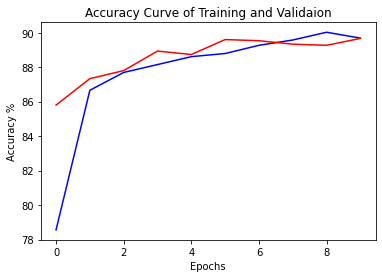

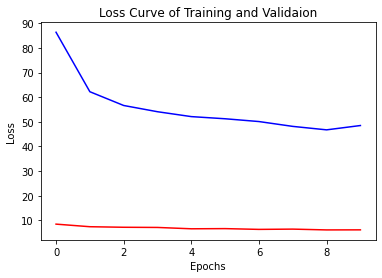

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


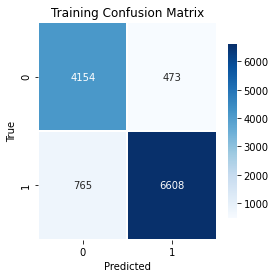

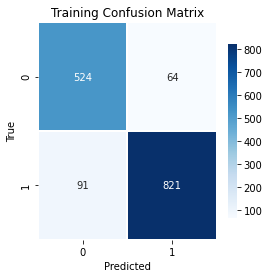

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times00

  resnet18.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # pbar = tqdm(enumerate(trainloader))
  train_p=[]
  train_l=[]
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = resnet18(inputs)               #----> forward pass
    _, predicted = torch.max(outputs.data, 1)

    loss = criterion(outputs, labels)   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    total_correct += get_num_correct(outputs, labels)
    

    train_p.extend(predicted.cpu().numpy())
    train_l.extend(labels.cpu().numpy())
    
    pbar.set_description(
              'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, i * len(inputs), len(trainloader.dataset),
                  100. * i / len(trainloader),
                  loss.data.item()))

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss)
  torch.save(resnet18,"res18_FC_LastLayer4.pth")

  resnet18.eval()
  from sklearn.metrics import confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = resnet18(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          loss = criterion(outputs, labels)
          running_loss += loss.item()

          valid_p.extend(predicted.cpu().numpy())
          valid_l.extend(labels.cpu().numpy())

  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss)
  print(" ")

print("Training Accuracy",a,"%")
print("Validation Accuracy",((100 * correct) / total),"%")
print('Finished Training')

plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)

import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()


Testing

Accuracy of the Resnet-18 on the test images: 96 %
F1 Score : 0.9666666666666667


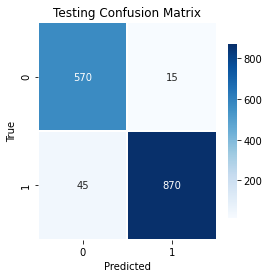

In [0]:
resnet18=torch.load("res18_FC_LastLayer4.pth")

resnet18.eval()


from sklearn.metrics import confusion_matrix
correct = 0
total = 0
p=[]
l=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        p.extend(predicted.cpu().numpy())
        l.extend(labels.cpu().numpy())

print('Accuracy of the Resnet-18 on the test images: %d %%' % (
    100 * correct / total))


# p=np.array(p)
# l=np.array(l)
input=confusion_matrix(p,l)
# print 'Confusion Matrix :'
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(input,cmap="Blues", annot=True,fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix")
# ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=22)
# ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=22)

# F1 Score . . . . .

from sklearn.metrics import f1_score

print("F1 Score :",f1_score(l, p)) # p are predicted labels and l are true labels


# Train VGG16 Unfreeze last 6 convolutions and FC **layer**

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True,progress=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [0]:
features = list(vgg16.classifier.children())[:-7] # Remove last FC layers
features
for para in vgg16.features.parameters():
  para.require_grad=False
  # print(para.require_grad)

for k in vgg16.features.parameters():
  k.requires_grad=False
    

  # print(k.requires_grad)
  

In [0]:
features.extend([nn.Linear(in_features=25088,out_features=630+100,bias=True)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5,inplace=False)])
features.extend([nn.Linear(in_features=630+100,out_features=2,bias=False)])
features

vgg16.classifier=nn.Sequential(*features)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:

# Freeze last 3 features convolution layers

for n,k in vgg16.named_parameters():

  if(n == 'features.17.weight' or n == 'features.17.bias'):
    k.requires_grad = True
  if(n == 'features.19.weight' or n == 'features.19.bias'):
    k.requires_grad = True
  if(n == 'features.21.weight' or n == 'features.21.bias'):
    k.requires_grad = True

  if(n == 'features.24.weight' or n == 'features.24.bias'):
    k.requires_grad = True
  if(n == 'features.26.weight' or n == 'features.26.bias'):
    k.requires_grad = True
  if(n == 'features.28.weight' or n == 'features.28.bias'):
    k.requires_grad = True

  print(n, k.requires_grad)

for param in vgg16.parameters():
  print(counter,param.requires_grad)
  counter+=1 


features.0.weight False
features.0.bias False
features.2.weight False
features.2.bias False
features.5.weight False
features.5.bias False
features.7.weight False
features.7.bias False
features.10.weight False
features.10.bias False
features.12.weight False
features.12.bias False
features.14.weight False
features.14.bias False
features.17.weight True
features.17.bias True
features.19.weight True
features.19.bias True
features.21.weight True
features.21.bias True
features.24.weight True
features.24.bias True
features.26.weight True
features.26.bias True
features.28.weight True
features.28.bias True
classifier.0.weight True
classifier.0.bias True
classifier.3.weight True
0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 True
15 True
16 True
17 True
18 True
19 True
20 True
21 True
22 True
23 True
24 True
25 True
26 True
27 True
28 True


In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)


In [0]:

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
# vg.train(mode=True)

Train Epoch: 0 [5984/12000 (99%)]	Loss: 0.235262: : 188it [06:10,  1.97s/it]


Train: epoch:  0 total_correct:  10083.0 total_loss:  68.60353548824787
Valid: epoch:  0 total_correct:  1339 total_loss:  6.031290769577026
 


Train Epoch: 1 [5984/12000 (99%)]	Loss: 0.232160: : 188it [05:08,  1.64s/it]


Train: epoch:  1 total_correct:  10686.0 total_loss:  51.075539499521255
Valid: epoch:  1 total_correct:  1346 total_loss:  6.292965292930603
 


Train Epoch: 2 [5984/12000 (99%)]	Loss: 0.281288: : 188it [05:09,  1.65s/it]


Train: epoch:  2 total_correct:  10840.0 total_loss:  46.605066545307636
Valid: epoch:  2 total_correct:  1349 total_loss:  5.908533677458763
 


Train Epoch: 3 [5984/12000 (99%)]	Loss: 0.257862: : 188it [05:06,  1.63s/it]


Train: epoch:  3 total_correct:  10833.0 total_loss:  44.62757045030594
Valid: epoch:  3 total_correct:  1364 total_loss:  5.2484405264258385
 


Train Epoch: 4 [5984/12000 (99%)]	Loss: 0.396278: : 188it [05:08,  1.64s/it]


Train: epoch:  4 total_correct:  10984.0 total_loss:  42.632654786109924
Valid: epoch:  4 total_correct:  1361 total_loss:  5.0048548728227615
 


Train Epoch: 5 [5984/12000 (99%)]	Loss: 0.188174: : 188it [05:01,  1.60s/it]


Train: epoch:  5 total_correct:  10988.0 total_loss:  40.95940166711807
Valid: epoch:  5 total_correct:  1361 total_loss:  5.67424188554287
 


Train Epoch: 6 [5984/12000 (99%)]	Loss: 0.251354: : 188it [05:06,  1.63s/it]


Train: epoch:  6 total_correct:  10996.0 total_loss:  40.86604196578264
Valid: epoch:  6 total_correct:  1358 total_loss:  5.857034265995026
 


Train Epoch: 7 [5984/12000 (99%)]	Loss: 0.122734: : 188it [05:08,  1.64s/it]


Train: epoch:  7 total_correct:  11028.0 total_loss:  40.01451829075813
Valid: epoch:  7 total_correct:  1366 total_loss:  5.213900178670883
 


Train Epoch: 8 [5984/12000 (99%)]	Loss: 0.215616: : 188it [05:08,  1.64s/it]


Train: epoch:  8 total_correct:  11063.0 total_loss:  38.73014438152313
Valid: epoch:  8 total_correct:  1375 total_loss:  5.135947965085506
 


Train Epoch: 9 [5984/12000 (99%)]	Loss: 0.140683: : 188it [05:08,  1.64s/it]


Train: epoch:  9 total_correct:  11030.0 total_loss:  39.67036101967096
Valid: epoch:  9 total_correct:  1371 total_loss:  4.801455348730087
 
Training Accuracy 91.91666666666667 %
Validation Accuracy 91.4 %
Finished Training


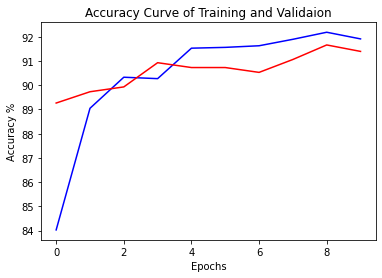

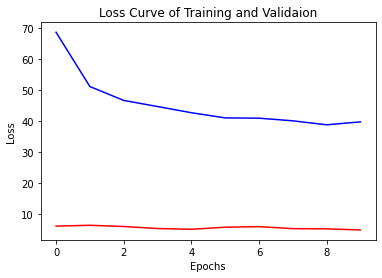

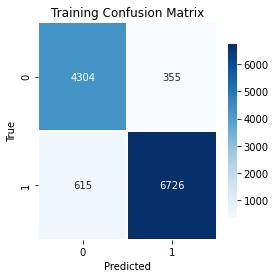

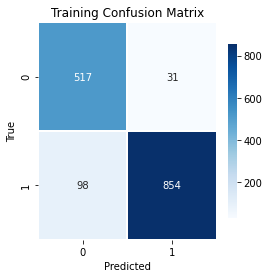

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

  vgg16.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # 
  train_p=[]
  train_l=[]
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = vgg16(inputs)               #----> forward pass
    _, predicted = torch.max(outputs.data, 1)

    loss = criterion(outputs, labels)   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    total_correct += get_num_correct(outputs, labels)
    

    train_p.extend(predicted.cpu().numpy())
    train_l.extend(labels.cpu().numpy())
    pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
  

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss)
  torch.save(vgg16,"vgg16_FC_Last6Conv.pth")

  vgg16.eval()
  from sklearn.metrics import confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = vgg16(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          loss = criterion(outputs, labels)
          running_loss += loss.item()

          valid_p.extend(predicted.cpu().numpy())
          valid_l.extend(labels.cpu().numpy())

  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss)
  print(" ")

print("Training Accuracy",a,"%")

print("Validation Accuracy",((100 * correct) / total),"%")

print('Finished Training')



plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)

import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()


Testing


In [8]:
vgg16=torch.load("vgg16_FC_Last6Conv.pth")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
vgg16.eval()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Accuracy of the network on the test images: 96 %
F1 Score : 0.9745575221238938


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


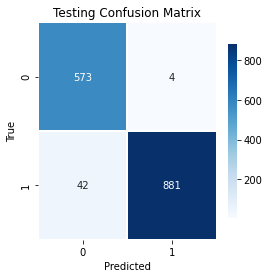

In [9]:
from sklearn.metrics import confusion_matrix
correct = 0
total = 0
p=[]
l=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        p.extend(predicted.cpu().numpy())
        l.extend(labels.cpu().numpy())

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))


# p=np.array(p)
# l=np.array(l)
input=confusion_matrix(p,l)
# print 'Confusion Matrix :'
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(input,cmap="Blues", annot=True,fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix")
# ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=22)
# ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=22)

from sklearn.metrics import f1_score

print("F1 Score :",f1_score(l, p)) # p are predicted labels and l are true labels


# Train Resnet18 Unfreeze last layer 3 and 4 convolution and FC layer





In [10]:
resnet18=models.resnet18(pretrained=True, progress=True)
resnet18
for param in resnet18.parameters():
  
  param.requires_grad=False
  param.require_grad=False

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [11]:
features=[]
features.extend([nn.Linear(in_features=512,out_features=630+100,bias=True)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5,inplace=False)])
features.extend([nn.Linear(in_features=630+100,out_features=2,bias=False)])
resnet18.fc=nn.Sequential(*features)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
for param in resnet18.layer4.parameters():
  param.requires_grad=True

for param in resnet18.layer3.parameters():
  param.requires_grad=True


for n,k in resnet18.named_parameters():
  print(n,k.requires_grad)

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2.bias False
layer2.0.downsample.0.weight False
layer2.0.downsample.1.weight False
layer2.0.downsample.1.bias False
layer2.1.conv1.weight False
layer2.1.bn1.weight False
layer2.1.bn1.bias False
layer2.1.conv2.weight False
layer2.1.bn2.weight False
layer2.1.bn2.bias False
layer3.0.conv1.weight True
layer3.0.bn1.weight True
layer3.0.bn1.bias True
layer3.0.conv2.weight True
layer3.0.bn2.weight True
layer3.0.bn2.bias True
layer3.0.downsample.0.weight True
layer3.0.downsample.1.weight True
laye

Training

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)


In [0]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
# vg.train(mode=True)

Train Epoch: 0 [5984/12000 (99%)]	Loss: 0.299910: : 188it [21:45,  6.94s/it]


Train: epoch:  0 total_correct:  9604.0 total_loss:  82.0820233374834
Valid: epoch:  0 total_correct:  1300 total_loss:  7.575467526912689
 


Train Epoch: 1 [5984/12000 (99%)]	Loss: 0.283231: : 188it [04:03,  1.30s/it]


Train: epoch:  1 total_correct:  10478.0 total_loss:  57.860304579138756
Valid: epoch:  1 total_correct:  1309 total_loss:  7.663934096693993
 


Train Epoch: 2 [5984/12000 (99%)]	Loss: 0.185132: : 188it [04:01,  1.28s/it]


Train: epoch:  2 total_correct:  10674.0 total_loss:  50.70934111624956
Valid: epoch:  2 total_correct:  1346 total_loss:  6.210253491997719
 


Train Epoch: 3 [5984/12000 (99%)]	Loss: 0.207716: : 188it [04:01,  1.29s/it]


Train: epoch:  3 total_correct:  10717.0 total_loss:  49.48402114212513
Valid: epoch:  3 total_correct:  1333 total_loss:  6.485155448317528
 


Train Epoch: 4 [5984/12000 (99%)]	Loss: 0.293669: : 188it [04:02,  1.29s/it]


Train: epoch:  4 total_correct:  10808.0 total_loss:  47.0827552229166
Valid: epoch:  4 total_correct:  1341 total_loss:  6.331955134868622
 


Train Epoch: 5 [5984/12000 (99%)]	Loss: 0.481384: : 188it [04:01,  1.28s/it]


Train: epoch:  5 total_correct:  10862.0 total_loss:  45.982433781027794
Valid: epoch:  5 total_correct:  1342 total_loss:  6.000239096581936
 


Train Epoch: 6 [5984/12000 (99%)]	Loss: 0.128766: : 188it [03:58,  1.27s/it]


Train: epoch:  6 total_correct:  10859.0 total_loss:  44.94186798483133
Valid: epoch:  6 total_correct:  1343 total_loss:  6.2707715928554535
 


Train Epoch: 7 [5984/12000 (99%)]	Loss: 0.175317: : 188it [03:57,  1.26s/it]


Train: epoch:  7 total_correct:  10882.0 total_loss:  43.838057570159435
Valid: epoch:  7 total_correct:  1348 total_loss:  5.637282393872738
 


Train Epoch: 8 [5984/12000 (99%)]	Loss: 0.082715: : 188it [03:58,  1.27s/it]


Train: epoch:  8 total_correct:  10943.0 total_loss:  41.81978838145733
Valid: epoch:  8 total_correct:  1342 total_loss:  6.35217060148716
 


Train Epoch: 9 [5984/12000 (99%)]	Loss: 0.182955: : 188it [03:56,  1.26s/it]


Train: epoch:  9 total_correct:  10973.0 total_loss:  41.867664597928524
Valid: epoch:  9 total_correct:  1348 total_loss:  6.023751363158226
 
Training Accuracy 91.44166666666666 %
Validation Accuracy 89.86666666666666 %
Finished Training


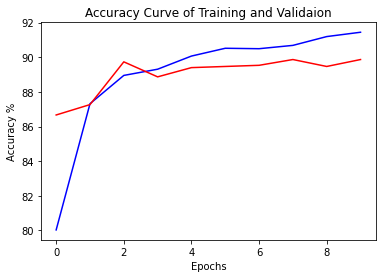

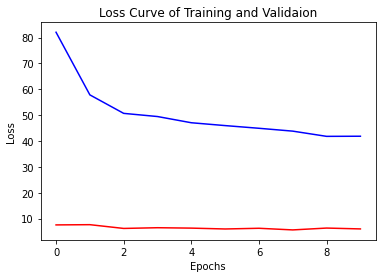

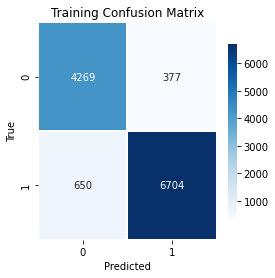

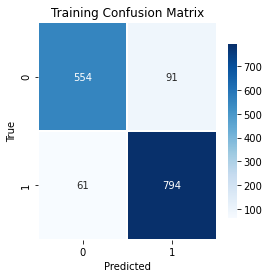

In [15]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times00

  resnet18.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # pbar = tqdm(enumerate(trainloader))
  train_p=[]
  train_l=[]
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = resnet18(inputs)               #----> forward pass
    _, predicted = torch.max(outputs.data, 1)

    loss = criterion(outputs, labels)   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    total_correct += get_num_correct(outputs, labels)
    

    train_p.extend(predicted.cpu().numpy())
    train_l.extend(labels.cpu().numpy())
    
    pbar.set_description(
              'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, i * len(inputs), len(trainloader.dataset),
                  100. * i / len(trainloader),
                  loss.data.item()))

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss)
  torch.save(resnet18,"res18_FC_LastLayers_4_3.pth")

  resnet18.eval()
  from sklearn.metrics import confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = resnet18(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          loss = criterion(outputs, labels)
          running_loss += loss.item()

          valid_p.extend(predicted.cpu().numpy())
          valid_l.extend(labels.cpu().numpy())

  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss)
  print(" ")

print("Training Accuracy",a,"%")
print("Validation Accuracy",((100 * correct) / total),"%")
print('Finished Training')

plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)

import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()


Testing

Accuracy of the Resnet-18 on the test images: 96 %
F1 Score : 0.9690837549184936


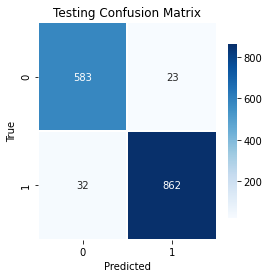

In [16]:
resnet18=torch.load("res18_FC_LastLayers_4_3.pth")

resnet18.eval()


from sklearn.metrics import confusion_matrix
correct = 0
total = 0
p=[]
l=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        p.extend(predicted.cpu().numpy())
        l.extend(labels.cpu().numpy())

print('Accuracy of the Resnet-18 on the test images: %d %%' % (
    100 * correct / total))


# p=np.array(p)
# l=np.array(l)
input=confusion_matrix(p,l)
# print 'Confusion Matrix :'
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(input,cmap="Blues", annot=True,fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix")
# ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=22)
# ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=22)

# F1 Score . . . . .

from sklearn.metrics import f1_score

print("F1 Score :",f1_score(l, p)) # p are predicted labels and l are true labels
